In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

train = pd.read_csv('/content/sales_train.csv')
# test = pd.read_csv('/content/test.csv')
shops = pd.read_csv('/content/shops.csv')
items = pd.read_csv('/content/items.csv')
# item_categories = pd.read_csv('/content/item_categories.csv')

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

Возможные фичи:
1. Продажи в этом месяце в прошлые года
2. **Продажи за последние n месяцев**
3. Цена товара
4. Город продажи. Город можно заменить или совместно использовать с численностью населения или какой-нибудь характеристикой благосостояния города
5. **Общие продажи магазина**
6. **Общие продажи этого товара вообще или в конкретном городе**
7. Продажи этого товара в лейбле магазина в разных городах(напр. ТЦ "Мега" в Воронеже и Омске)
8. Какие-нибудь харакретистики прибыльности магазина, типа общего оборота
9. Категории и подкатегории товара
10. Вид магазина(ТЦ, ТРЦ и т.д.)
11. Общие продажи по категории/подкатегории товара
12. Средняя цена по этой категории/подкатегории
13. Добавить еще 1 подкатегорию(напр. сейчас есть [игры -> [PS4, PS5, Xbox One, Xbox 360]], и выделить оттуда консоли, т.е. [игры -> [PS -> [PS4, PS5]], [Xbox -> [Xbox One, Xbox 360]]]. Но это только если очень захочется эту фичу добавить.
14. Количество товаров в каждой категории
15. Количество магазинов в городе
16. Продажи по категориям/магазинам/городам в предыдущие месяца
17. Количество дней в месяце
18. Количество выходных/праздничных дней в месяце
19. Время с последней продажи в этом магазине либо этого товара, либо вообще
20. Месяц, в котором у товара были наибольшие продажи(если есть связь с годами)
21. Id продукта
22. Id магазина
23. **Месяц продажи**

Общие продажи магазинов

In [4]:
average_sales_shops = train.groupby(by='shop_id')['item_cnt_day'].sum()

Общие продажи товаров

In [5]:
average_sales_items = train.groupby(by='item_id')['item_cnt_day'].sum()

Добавление пропущенных значений(нулей)

In [6]:
train = train.drop(columns=['item_price', 'date'])

In [7]:
#уникальные [shop_id, item_id]
updated_train = train.drop_duplicates(subset=['item_id','shop_id'])[['shop_id', 'item_id']]

#merge with zeros
updated_train['key'] = 1
zeros = pd.DataFrame(range(34))
zeros.columns = ['date_block_num']
zeros['key'] = 1
updated_train = updated_train.merge(zeros, how='outer', on='key').drop('key', 1)

#sum of items on months
train = train.groupby(by=['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().reset_index()
updated_train = updated_train.merge(train, on=['shop_id', 'item_id','date_block_num'], how='left')
updated_train = updated_train.fillna(0)

Продажи товара в предыдущие ```window``` месяцев



In [8]:
def sales_prev_year(df, lag):
  df['sales_month_prev_year'] = df.date_block_num - lag
  shifted = df.copy()
  shifted = shifted[['shop_id', 'item_id', 'date_block_num', 'item_cnt_day']]
  shifted = shifted.rename(columns={'date_block_num' :'sales_month_prev_year'})
  df = df.merge(shifted, how='left', on=['shop_id', 'item_id', 'sales_month_prev_year'])
  df = df.rename(columns={"item_cnt_day_y":"sales_" + str(lag) +"_month_ago", "item_cnt_day_x":"item_cnt_day"})

  return df

In [9]:
window = 13
for i in range(1, window):
  updated_train["sales_" + str(i) +"_month_ago"] = updated_train['item_cnt_day'].shift(periods=i)

Удаление первых ```window ``` месяцев



In [10]:
updated_train = updated_train[updated_train['date_block_num'] > window - 2]

Добавление общих продаж магазинов и товаров

In [11]:
updated_train = updated_train.merge(average_sales_shops, how='left', on='shop_id')
updated_train = updated_train.rename(columns={"item_cnt_day_x" : "item_cnt_day", "item_cnt_day_y":"shop_sales"})
updated_train = updated_train.merge(average_sales_items, how='left', on='item_id')
updated_train = updated_train.rename(columns={"item_cnt_day_x" : "item_cnt_day", "item_cnt_day_y": "item_sales"})

In [12]:
updated_train = updated_train.drop(columns=['item_id', 'shop_id'])

In [13]:
updated_train = updated_train.sort_values(by='date_block_num')

In [14]:
X = updated_train.drop(columns='item_cnt_day')
target = updated_train['item_cnt_day']

**Decision Tree**

In [22]:
scores = []
dtr = DecisionTreeRegressor(criterion='mae', max_depth=4)
scaler = StandardScaler()

In [ ]:
for i in range(20, 30):
  print(i)
  X_tree_train = X[X['date_block_num'] == i][:100000]
  y_train = updated_train[updated_train['date_block_num'] == i]['item_cnt_day'][:100000]
  X_test = X[X['date_block_num'] == i][100000:200000]
  y_test = updated_train[updated_train['date_block_num'] == i]['item_cnt_day'][100000:200000]
  %time dtr.fit(scaler.fit_transform(X_tree_train), y_train)
  scores.append(mean_absolute_error(dtr.predict(scaler.fit_transform(X_test)), y_test))

20
CPU times: user 4min 59s, sys: 21.6 ms, total: 4min 59s
Wall time: 4min 59s
21
CPU times: user 4min 58s, sys: 9 ms, total: 4min 58s
Wall time: 4min 58s
22
CPU times: user 5min 17s, sys: 30 ms, total: 5min 17s
Wall time: 5min 17s
23
CPU times: user 4min 58s, sys: 12 ms, total: 4min 58s
Wall time: 4min 58s
24
CPU times: user 4min 45s, sys: 17 ms, total: 4min 45s
Wall time: 4min 46s
25
CPU times: user 4min 51s, sys: 13 ms, total: 4min 51s
Wall time: 4min 52s
26
CPU times: user 4min 54s, sys: 20 ms, total: 4min 54s
Wall time: 4min 54s
27
CPU times: user 5min, sys: 17 ms, total: 5min
Wall time: 5min
28
CPU times: user 4min 55s, sys: 15 ms, total: 4min 55s
Wall time: 4min 55s
29
CPU times: user 5min 17s, sys: 20 ms, total: 5min 17s
Wall time: 5min 17s


In [ ]:
np.array(scores).mean()

0.24237549999999994

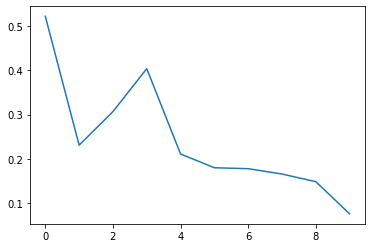

In [ ]:
plt.plot(scores)

**Linear Regression**

In [ ]:
X['date_block_num'].nunique()

22

In [ ]:
tscv = TimeSeriesSplit(n_splits=22)

In [42]:
lr = LinearRegression()
%time scores = cross_val_score(lr, scaler.fit_transform(X), target, cv=tscv, scoring=make_scorer(mean_absolute_error))


CPU times: user 59.3 s, sys: 7.87 s, total: 1min 7s
Wall time: 47.2 s


In [43]:
scores.mean()

0.16159260437307166

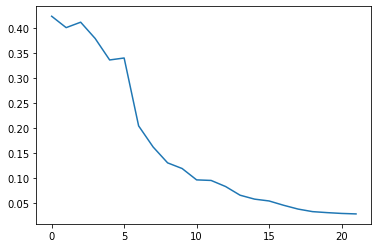

In [44]:
plt.plot(scores)

**Random Forest**

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
tscv_forest = TimeSeriesSplit(n_splits=4)

In [46]:
rfr = RandomForestRegressor(max_depth=1, criterion='mae', n_estimators=1, verbose=10)

In [47]:
%time rfr.fit(X_forest, target_forest)

building tree 1 of 1
CPU times: user 76.3 ms, sys: 1.95 ms, total: 78.2 ms
Wall time: 82.7 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=1, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=None, oob_score=False,
                      random_state=None, verbose=10, warm_start=False)

In [48]:
mean_absolute_error(rfr.predict(X[X['date_block_num'] == 30]), updated_train[updated_train['date_block_num'] == 30]['item_cnt_day'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


0.0

In [49]:
%time scores = cross_val_score(rfr, scaler.fit_transform(X_forest), target_forest, cv=tscv_forest, scoring=make_scorer(mean_absolute_error), verbose=3)


[CV]  ................................................................
building tree 1 of 1
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
[CV] .................................... , score=0.000, total=   0.0s
[CV]  ................................................................
building tree 1 of 1
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
[CV] .................................... , score=0.000, total=   0.0s
[CV]  ................................................................
building tree 1 of 1
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
[CV] .................................... , score=0.000, total=   0.1s
[CV]  ................................................................
building tree 1 of 1
Using ThreadingBackend as joblib

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s rema

In [53]:
scores.mean()

0.0

**BaggingRegressor**

In [51]:
br = BaggingRegressor(base_estimator=dtr, n_estimators=10, oob_score=True)
%time br.fit(scaler.fit_transform(X_forest), target_forest)

CPU times: user 1.55 s, sys: 18.8 ms, total: 1.57 s
Wall time: 1.57 s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:1056: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mae',
                                                      max_depth=4,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=True

In [54]:
mean_absolute_error(br.predict(X[X['date_block_num'] == 30]), updated_train[updated_train['date_block_num'] == 30]['item_cnt_day'])

0.0